In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

In [2]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=ncores, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P08010000', # Input your project ID here
    walltime='1:20:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(ncores)
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46041 instead
  http_address["port"], self.http_server.port


In [4]:
client

Client Scheduler: tcp://10.12.206.54:33570 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### A couple useful functions

In [101]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [5]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

### get the list of available members/files
- there were some model crashes
- therefore these are not necessarily sequential

In [6]:
histdir='/glade/scratch/djk2120/PPEn08/CTL2010/hist/'
tape='h0'
members=[]
files=[]
for i in np.arange(400):
    member='OAAT'+str(i).zfill(4)
    file=glob.glob(histdir+'*'+member+'*'+tape+'*.nc')
    if len(file)>0:
        members.append(member)
        files.append(file[0])

# work with 1 file
### notes 
- this is sparsegrid output, only 400 gridcells
- sparsegrid_landarea.nc can be used to recompose global mean
- xarray thinks cesm output starts in february

In [183]:
ds = xr.open_dataset(files[0])
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

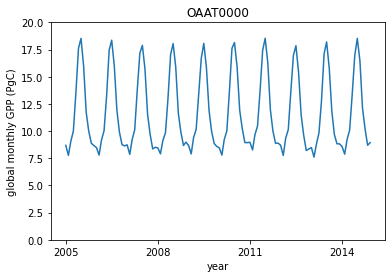

In [184]:
## make a global timeseries
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2
cf  = 1e-9*24*60*60*month_wts(10)   #gC/m2/s -> PgC/month
gpp = cf*(la*ds.GPP).sum(dim='gridcell')
gpp.plot()
plt.ylim([0,20])
plt.xlabel('year')
plt.ylabel('global monthly GPP (PgC)')
plt.title(members[0]);

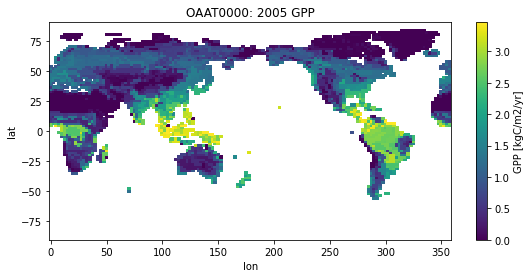

In [116]:
#calc 2005 gpp
ixt=ds['time.year']==2005
gpp2005 = 24*60*60/1000*(month_wts(1)*ds.GPP.isel(time=ixt)).sum(dim='time')
#set up some stuff for plotting
gpp2005.name='GPP'
gpp2005.attrs={'units':'kgC/m2/yr'}
#regrid to lat/lon
gpp2005_map = get_map(gpp2005)

#plot
plt.figure(figsize=[9,4])
gpp2005_map.plot()
plt.title(members[0]+': 2005 GPP');

# Work with multiple ensemble members

In [185]:
# defining a preprocessing function
#   this way I only take GPP and TWS
#   otherwise you'll read in ~500 data_vars (for h0)
data_vars=['GPP','TWS']
def preprocess(ds):
    return ds[data_vars]

In [186]:
%%time
ds=xr.open_mfdataset(files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

CPU times: user 2.04 s, sys: 72 ms, total: 2.11 s
Wall time: 13.1 s


In [187]:
#append some useful information about the parameters
csvfile='/glade/scratch/djk2120/PPEn08/OAAT_apr2020.csv'
keys=pd.read_csv(csvfile,header=None)
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
ds['param']  = xr.DataArray(params,dims='ens')
ds['minmax'] = xr.DataArray(minmax,dims='ens')

In [188]:
%%time
nyrs=10
gpp_ann      = 24*60*60*(month_wts(nyrs)*ds.GPP).sum(dim='time')/nyrs
gpp_ann_glob = 1e-9*(la*gpp_ann).sum(dim='gridcell').compute()


CPU times: user 2.14 s, sys: 104 ms, total: 2.25 s
Wall time: 11.4 s


Text(0, 0.5, 'avg GPP (PgC/yr)')

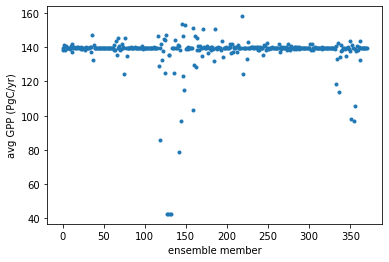

In [199]:
plt.plot(gpp_ann_glob,'.')
plt.xlabel('ensemble member')
plt.ylabel('avg GPP (PgC/yr)')


In [190]:
%%time
nyrs=10
tws_ann      = (month_wts(nyrs)*ds.TWS).sum(dim='time')/(365*nyrs)
tws_ann_glob = 1e-9*(la*tws_ann).sum(dim='gridcell').compute()

CPU times: user 2.74 s, sys: 77.7 ms, total: 2.82 s
Wall time: 12 s


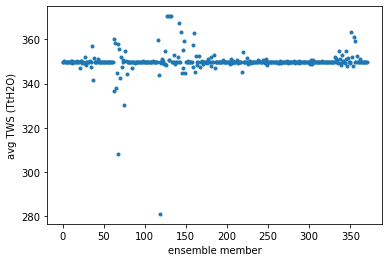

In [191]:
plt.plot(tws_ann_glob,'.')
plt.xlabel('ensemble member')
plt.ylabel('avg TWS (TtH2O)');

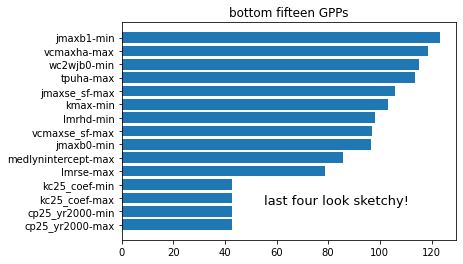

In [202]:
gpp_sort = np.sort(gpp_ann_glob)[:15]
ix       = np.argsort(gpp_ann_glob)[:15]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(15),gpp_sort)
plt.yticks(np.arange(15),ticks)
plt.title('bottom fifteen GPPs')
plt.text(55,1.5,'last four look sketchy!',fontsize=13);

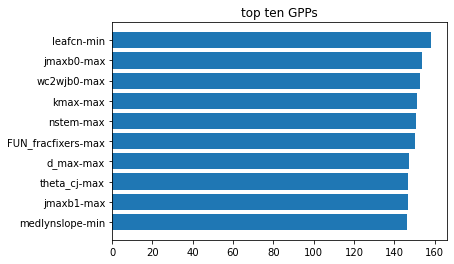

In [203]:
gpp_sort = np.sort(gpp_ann_glob)[-10:]
ix       = np.argsort(gpp_ann_glob)[-10:]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(10),gpp_sort)
plt.yticks(np.arange(10),ticks)
plt.title('top ten GPPs');

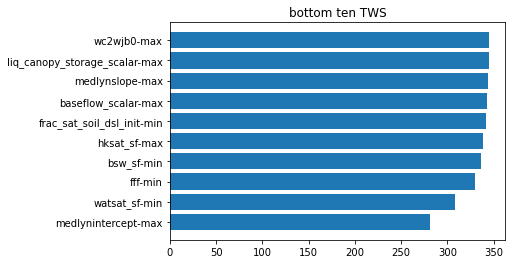

In [205]:
tws_sort = np.sort(tws_ann_glob)[:10]
ix       = np.argsort(tws_ann_glob)[:10]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(10),tws_sort)
plt.yticks(np.arange(10),ticks)
plt.title('bottom ten TWS');

top4 look sketchy (again)


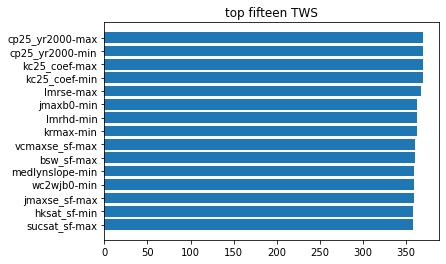

In [209]:
tws_sort = np.sort(tws_ann_glob)[-15:]
ix       = np.argsort(tws_ann_glob)[-15:]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(15),tws_sort)
plt.yticks(np.arange(15),ticks)
plt.title('top fifteen TWS');
print('top4 look sketchy (again)')